<a href="https://colab.research.google.com/github/jchen8000/MLDLwithPython/blob/main/4_08_Anomaly_Detection/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection

In [ ]:
%pip install \
  numpy==2.0.2 \
  scikit-learn==1.6.1 \
  matplotlib==3.10.0 \
  scipy==1.16.3

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from sklearn.metrics import f1_score

## Univariate Gaussian Distribution

There is a single variable, or single feature dataset:

$x = [ x_1, x_2, ... , x_n]$

The Univariate Gaussian Distribution is:

$\qquad p(x;\mu,\sigma^2) =  \displaystyle\frac{1}{\sigma\sqrt{2\pi}}e^{-\displaystyle\frac{(\mu-x)^2}{2\sigma^2}}$

where:

$\qquad \mu = \displaystyle\frac{1}{n}\sum_{i=1}^nx^{(i)}$

$\qquad \sigma^2 = \displaystyle\frac{1}{n}\sum_{i=1}^n\left( x^{(i)} - \mu \right)^2$

In [2]:
# Define normal distribution function based on above formula
def normal_distribution(x, mu, sigma):
  c = 1 / ( sigma * (2 * np.pi)**0.5 )
  e = ( (x-mu)/sigma )**2
  return c * np.e**(-0.5 * e)  

In [3]:
mu = 1.0
sigma = 1.0
np.random.seed(0)
X = np.random.normal(mu, sigma, size=100)

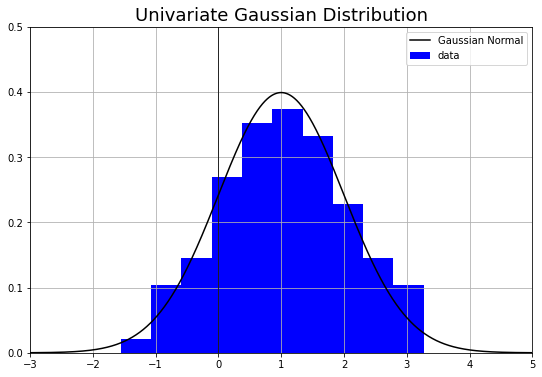

In [4]:
x = np.arange(-3, 5, 0.001)
plt.figure(figsize=(9,6))
plt.title("Univariate Gaussian Distribution", fontsize = 18)
plt.axis([-3, 5, 0, 0.5])
plt.hist(X, density=True, color='b', label='data')
plt.plot(x, normal_distribution(x, mu, sigma), c='k', label='Gaussian Normal')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linewidth=0.8)
plt.axvline(x=0, color='k', linewidth=0.8)
plt.savefig("univariate_gaussian.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

## Anomaly Detection with Multivariate Gaussian Distribution


$\qquad p(x; \mu, \Sigma)=\displaystyle\frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma|}}\exp\left(-\frac{1}{2}({x}-{\mu})^T{\boldsymbol\Sigma}^{-1}({x}-{\mu})\right)$

Where:

$\qquad\mu_j = \displaystyle\frac{1}{n}\sum_{i=1}^nx_j^{(i)}$

$\qquad \sigma_j^2 = \displaystyle\frac{1}{n}\sum_{i=1}^n\left( x_j^{(i)} - \mu_j \right)^2$

$\qquad x$ is a matrix of $n \times m$, $x = \begin{bmatrix}
x_{11} & ... & x_{1m} \\
x_{21} & ... & x_{2m} \\
... & ... & ... \\
x_{n1} & ... & x_{nm} 
\end{bmatrix}$

$\qquad n$ is the number of data points and $m$ is the number of features. 

$\qquad μ$ is the mean, it's an m-dimensional vector, $\begin{bmatrix}
\mu_1 & ... & \mu_m \\
\end{bmatrix}$

$\qquad Σ$ is the covariance matrix of size $m \times m$.


Anomaly Detection for 2 Features

In [5]:
from sklearn.datasets import make_blobs
X_nor, y_nor = make_blobs(n_samples=600, centers=1, cluster_std=0.4, random_state=2)

#Add anomaly points to the dataset
np.random.seed(2)
X_abn = np.random.normal(np.mean(X_nor, axis=0), 
                         np.std(X_nor, axis=0) * 4, 
                         size=[10, 2])
y_abn = np.ones(10)
X = np.concatenate((X_nor, X_abn))
y = np.concatenate((y_nor, y_abn))

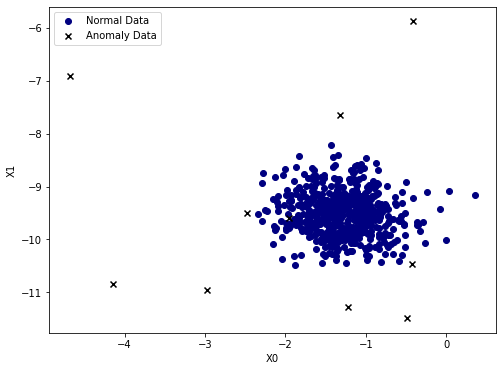

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X_nor[:, 0], X_nor[:, 1], c='navy', marker='o', label='Normal Data')
plt.scatter(X_abn[:, 0], X_abn[:, 1], c='k', marker='x', label='Anomaly Data')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.savefig("anomaly_detection_data.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

In [7]:
def estimate_gaussian(X):
    n, m = X.shape
    mu = 1/n * np.sum(X,axis=0)
    sigma_ = 1/n * np.sum((X - mu)**2, axis=0)
    sigma = np.zeros((m, m))
    np.fill_diagonal(sigma, sigma_)
    return mu, sigma

def normal_distribution_2d(x, y, mu, Sigma):
    n = 2                             # because this is 2-D normal distribution
    sigma_det = np.linalg.det(Sigma)  # determinant of Sigma
    c = 1.0 / ((2 * np.pi)**n * sigma_det)**0.5
    
    sigma_inv = np.linalg.inv(Sigma)  # inverse of Sigma (2x2 matrix)
    e = ( ( x-mu[0] )**2 * sigma_inv[0,0] + 
          ( x-mu[0] ) * ( y-mu[1] ) * (sigma_inv[0,1] + sigma_inv[1,0]) + 
          ( y-mu[1] )**2 * sigma_inv[1,1]
        )
    return c * np.e ** (-0.5 * e)

mu, sigma = estimate_gaussian(X)

p = normal_distribution_2d(X[:,0], X[:,1], mu, sigma)
p_nor = p[np.where(y == 0)]
p_abn = p[np.where(y == 1)]


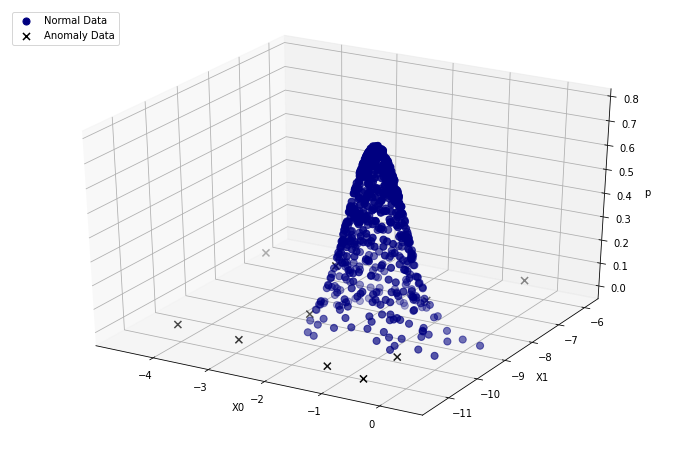

In [8]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(projection='3d')
ax.grid(True)
ax.scatter3D(X_nor[:, 0], X_nor[:, 1], p_nor, c='navy', marker='o', s=50, label='Normal Data')
ax.scatter3D(X_abn[:, 0], X_abn[:, 1], p_abn, c='k', marker='x', s=50, label='Anomaly Data')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('p')
plt.legend(loc=2)
plt.savefig("anomaly_detection_3d.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

F1 score =  0.9934426229508196


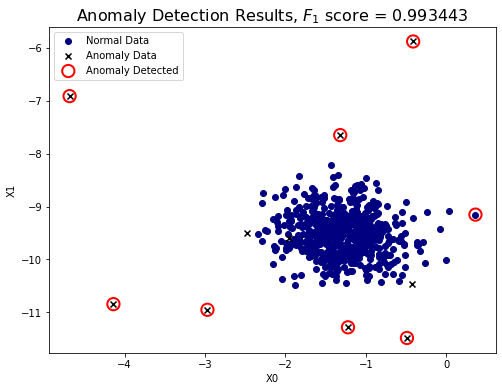

In [9]:
epsilon = 0.001
predict = (p < epsilon)

f1 = f1_score(y, predict, average='micro') 
print("F1 score = ", f1)

X_pred = X[np.where(predict == 1)]
p_pred = predict[np.where(predict == 1)]

plt.figure(figsize=(8,6))
plt.scatter(X_nor[:, 0], X_nor[:, 1], c='navy', marker='o', label='Normal Data')
plt.scatter(X_abn[:, 0], X_abn[:, 1], c='k', marker='x', label='Anomaly Data')
plt.scatter(X_pred[:, 0], X_pred[:, 1], s=150, edgecolors='r', facecolors='None', linewidth=2, label='Anomaly Detected')
plt.xlabel("X0")
plt.ylabel('X1')
plt.legend(loc='best')
plt.title("Anomaly Detection Results, $F_1$ score = %f" % f1, fontsize=16)
plt.savefig("anomaly_detection_detected.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

In [10]:
def select_threshold(yval, pval):
    bestF1 = 0
    bestEpsilon = 0
    s = int(math.log(pval.min(), 10))
    for exponent in range(s, -1):
        epsilon = 10**exponent
        pred = (pval < epsilon)
        f1 = f1_score(yval, pred, average='micro')
        if f1 >= bestF1:
            bestF1 = f1
            bestEpsilon = epsilon
    return bestF1, bestEpsilon

f1, epsilon = select_threshold(y, p)
print("Best F1 score = ", f1)
print("Best anomaly threshold = ", epsilon)

Best F1 score =  0.9934426229508196
Best anomaly threshold =  0.001


### Anomaly Detection for Multiple (More than 2) Features

In [11]:
features = 8
X_nor2, y_nor2 = make_blobs(n_samples=600, n_features=features, centers=1, cluster_std=0.4, random_state=2)

#Add anomaly points to the dataset
np.random.seed(2)
X_abn2 = np.random.normal(np.mean(X_nor2, axis=0), 
                         np.std(X_nor2, axis=0) * 2, 
                         size=[10, features])
y_abn2 = np.ones(10)
X2 = np.concatenate((X_nor2, X_abn2))
y2 = np.concatenate((y_nor2, y_abn2))

In [12]:
mu2, sigma2 = estimate_gaussian(X2)
p2 = multivariate_normal.pdf(X2, mu2, sigma2)
epsilon2 = 1e-04
predict2 = (p2 < epsilon2)
f12 = f1_score(y2, predict2, average='micro')
print("F1 score", f12)

F1 score 0.9770491803278688


In [13]:
f12, epsilon2 = select_threshold(y2, p2)
print("Best F1 score = ", f12)
print("Best anomaly threshold = ", epsilon2)

Best F1 score =  0.9950819672131147
Best anomaly threshold =  1e-06


## Anomaly Detection with Gaussian Mixture 

In [14]:
X_nor3, y_nor3 = make_blobs(n_samples=800, centers=3, cluster_std=0.4, random_state=0)
y_nor3[:] = 0
#Add anomaly points to the dataset
np.random.seed(0)
X_abn3 = np.random.normal(np.mean(X_nor3, axis=0), 
                          np.std(X_nor3, axis=0) * 1.2, 
                          size=[20, 2])
y_abn3 = np.ones(20)
X3 = np.concatenate((X_nor3, X_abn3))
y3 = np.concatenate((y_nor3, y_abn3))

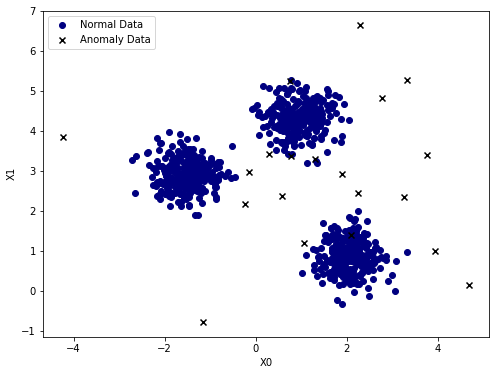

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(X_nor3[:, 0], X_nor3[:, 1], c='navy', marker='o', label='Normal Data')
plt.scatter(X_abn3[:, 0], X_abn3[:, 1], c='k', marker='x', label='Anomaly Data')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(loc=2)
plt.savefig("anomaly_detection_mixture.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

In [16]:
from sklearn.mixture import GaussianMixture

# Build a Gaussian Mixture Model
gm = GaussianMixture(n_components=3, random_state=42)

# Fit the data
gm.fit(X3)

GaussianMixture(n_components=3, random_state=42)

Threshold -4.949169107412425


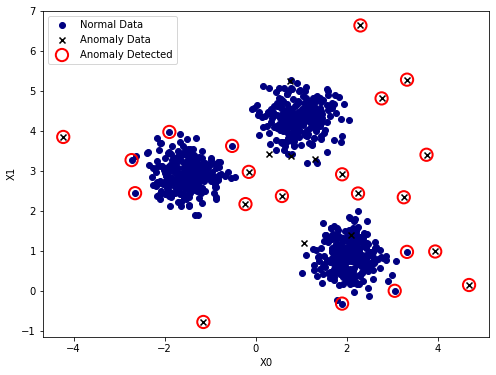

In [17]:
# Get the score for each sample
p3 = gm.score_samples(X3)
# Get the score threshold for anomaly
threshold = np.percentile(p3, 2.5)
print("Threshold", threshold) 
predict3 = (p3 < threshold)
X_pred = X3[np.where(predict3 == 1)]

plt.figure(figsize=(8,6))
plt.scatter(X_nor3[:, 0], X_nor3[:, 1], c='navy', marker='o', label='Normal Data')
plt.scatter(X_abn3[:, 0], X_abn3[:, 1], c='k', marker='x', label='Anomaly Data')
plt.scatter(X_pred[:, 0], X_pred[:, 1], s=150, edgecolors='r', facecolors='None', linewidth=2, label='Anomaly Detected')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(loc=2)
plt.savefig("anomaly_detection_mixture_detected.svg", format="svg", transparent=True, bbox_inches='tight')
plt.show()

In [18]:
f13 = f1_score(y3, predict3, average='micro')
print("F1 score", f13)

F1 score 0.9841463414634146


In [19]:
def select_threshold3(yval, pval):
    bestF1 = 0
    bestPercentage = 0
    for percentage in range(0, 101, 5):
        threshold = np.percentile(pval, percentage/10)
        pred = (pval < threshold)
        f1 = f1_score(yval, pred, average='micro')
        if f1 >= bestF1:
            bestF1 = f1
            bestPercentage = percentage/10
    return bestF1, bestPercentage

f13, percentage3 = select_threshold3(y3, p3)
print("Best F1 score = ", f13)
print("Best Percentage = ", percentage3)

Best F1 score =  0.9914634146341463
Best Percentage =  1.5
